# Treeflow example - carnivores data

Dataset from **Suchard, Marc A., and Andrew Rambaut. "Many-core algorithms for statistical phylogenetics." *Bioinformatics* 25.11 (2009): 1370-1376.**

Sequences accessed from [Beast examples on Github](https://github.com/beast-dev/beast-mcmc/blob/v1.10.4/examples/Benchmarks/benchmark2.xml).

In [1]:
import treeflow

2022-09-20 20:58:41.341751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 20:58:41.341768: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read input data

In [2]:
tree = treeflow.convert_tree_to_tensor(treeflow.parse_newick("demo-data/carnivores.newick"))
tree.node_heights

2022-09-20 20:58:44.224796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 20:58:44.224975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 20:58:44.225002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-20 20:58:44.225024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-20 20:58:44.225046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

<tf.Tensor: shape=(61,), dtype=float64, numpy=
array([0.05845 , 0.07205 , 0.08652 , 0.047   , 0.06448 , 0.08533 ,
       0.12308 , 0.30126 , 0.03246 , 0.05344 , 0.05663 , 0.01815 ,
       0.08589 , 0.08867 , 0.10523 , 0.03805 , 0.01402 , 0.01425 ,
       0.00839 , 0.0166  , 0.01789 , 0.05223 , 0.06599 , 0.11039 ,
       0.15421 , 0.0116  , 0.03125 , 0.04048 , 0.04165 , 0.04424 ,
       0.04595 , 0.03913 , 0.05364 , 0.09306 , 0.20766 , 0.25459 ,
       0.12729 , 0.15951 , 0.02638 , 0.10512 , 0.16417 , 0.17777 ,
       0.19941 , 0.32409 , 0.12283 , 0.35432 , 0.36806 , 0.38553 ,
       0.04165 , 0.04812 , 0.00993 , 0.05352 , 0.06244 , 0.14523 ,
       0.19857 , 0.385531, 0.02982 , 0.05469 , 0.16975 , 0.45712 ,
       0.46942 ])>

] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2022-09-20 20:58:44.225092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-09-20 20:58:44.225113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2022-09-20 20:58:44.225136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-20 20:58:44.225141: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are inst

In [3]:
alignment = treeflow.Alignment("demo-data/carnivores.fasta").get_compressed_alignment()
alignment

WeightedAlignment(taxon_count=62, pattern_count=5565)

## Model specification

### Single kappa parameter across tree

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
from treeflow import float_constant as c
from treeflow.evolution.substitution import HKY, get_transition_probabilities_tree
from tensorflow_probability.python.distributions import (
    JointDistributionNamed,
    Gamma,
    LogNormal,
    Dirichlet
)
from treeflow.distributions import (
    DiscretizedDistribution,
    DiscreteParameterMixture,
    LeafCTMC,
    SampleWeighted,
    Yule
)


site_category_count = 4
pattern_counts = alignment.get_weights_tensor()
subst_model = HKY()

def build_sequence_dist(tree, kappa, frequencies, site_gamma_shape):
    unrooted_tree = tree.get_unrooted_tree()
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    transition_probs_tree = get_transition_probabilities_tree(
        unrooted_tree,
        subst_model,
        rate_categories=site_rate_distribution.normalised_support,
        frequencies=frequencies,
        kappa=kappa
    )
    return SampleWeighted(
        DiscreteParameterMixture(
            site_rate_distribution,
            LeafCTMC(
                transition_probs_tree,
                tf.expand_dims(frequencies, -2),
            ),
        ),
        sample_shape=alignment.site_count,
        weights=pattern_counts
    )
    

base_model = tfp.distributions.JointDistributionNamed(dict(
    birth_rate=LogNormal(c(1.0), c(1.5)),
    tree=lambda birth_rate: Yule(tree.taxon_count, birth_rate, name="tree"),
    kappa=LogNormal(c(0.0), c(2.0)),
    site_gamma_shape=LogNormal(c(0.0), c(1.0)),
    frequencies=Dirichlet(c([2.0, 2.0, 2.0, 2.0])),
    sequences=build_sequence_dist
))
base_model_pinned = base_model.experimental_pin(sequences=alignment.get_encoded_sequence_tensor(tree.taxon_set))
prior_samples = base_model_pinned.sample_unpinned()
prior_samples.keys()

/home/christiaan/uni/treeflow/treeflow/distributions/tree/birthdeath/birth_death_contemporary_sampling.py:69: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")
/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


/home/christiaan/uni/treeflow/treeflow/distributions/leaf_ctmc.py:62: UserWarning: Dummy sampling of alignment
  warnings.warn("Dummy sampling of alignment")


dict_keys(['birth_rate', 'tree', 'site_gamma_shape', 'kappa', 'frequencies'])

CPU times: user 10h 15s, sys: 21min 19s, total: 10h 21min 35s
Wall time: 57min 2s


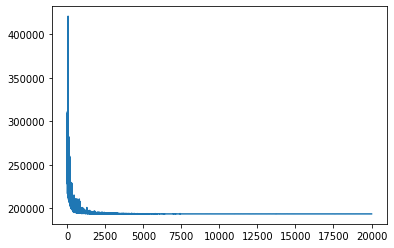

In [8]:
%%time
from treeflow.vi import fit_fixed_topology_variational_approximation, RobustOptimizer
import matplotlib.pyplot as plt

optimizer = RobustOptimizer(tf.optimizers.Adam(learning_rate=0.01))
num_steps = 20000
base_approx, (base_loss, base_vars) = fit_fixed_topology_variational_approximation(
    base_model_pinned,
    topologies=dict(tree=tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
    init_loc=dict(tree=tree)
)
plt.plot(base_loss)

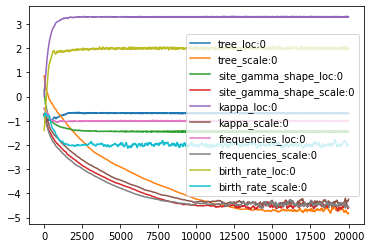

In [9]:
for varname, value in base_vars.items():
    np_value = value.numpy()
    if len(np_value.shape) > 1:
        np_value = np_value[:, -1]
    plt.plot(np_value, label=varname)
plt.legend()

/home/christiaan/uni/treeflow/treeflow/distributions/tree/birthdeath/birth_death_contemporary_sampling.py:69: UserWarning: Dummy sampling
  warnings.warn("Dummy sampling")


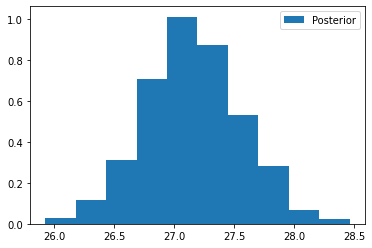

In [10]:
n_samples = 1000
base_samples = base_approx.sample(n_samples)
prior_samples = base_model_pinned.sample_unpinned(n_samples)

plt.hist(base_samples["kappa"].numpy(), label="Posterior", density=True)
plt.legend()

(array([  9.,  45., 104., 196., 261., 196., 129.,  44.,  12.,   4.]),
 array([0.48864362, 0.49123148, 0.49381934, 0.49640721, 0.49899507,
        0.50158293, 0.50417079, 0.50675866, 0.50934652, 0.51193438,
        0.51452225]),
 <BarContainer object of 10 artists>)

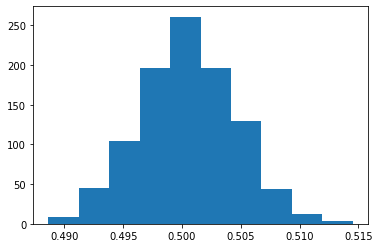

In [12]:
plt.hist(base_samples["tree"].node_heights[:, -1].numpy())

In [16]:
from treeflow.tree.io import write_tensor_trees
from treeflow.model.io import write_samples_to_file

base_out_samples = dict(base_samples)
base_tree_samples = base_out_samples.pop("tree")
write_tensor_trees(
    "demo-data/carnivores.newick", base_tree_samples.branch_lengths, "demo-out/carnivores-base-trees.nexus"
)
write_samples_to_file(
    base_samples,
    base_model_pinned,
    "demo-out/carnivores-base-samples.csv",
    vars=base_out_samples.keys(), tree_vars=dict(tree=base_tree_samples)
)

### Per site kappa parameter

In [5]:
def build_sequence_dist_alt(tree, kappa, frequencies, site_gamma_shape):
    # kappa has shape (..., n_branches)
    unrooted_tree = tree.get_unrooted_tree()
    site_rate_distribution = DiscretizedDistribution(
        category_count=site_category_count,
        distribution=tfp.distributions.Gamma(concentration=site_gamma_shape, rate=site_gamma_shape),
    )
    frequencies_b = tf.broadcast_to(tf.expand_dims(frequencies, -2), kappa.shape + (4,))
    transition_probs_tree = get_transition_probabilities_tree(
        unrooted_tree,
        subst_model,
        rate_categories=site_rate_distribution.normalised_support,
        frequencies=frequencies_b,
        kappa=kappa,
        inner_batch_rank=1,
        batch_rank=-1 # Don't add a batch dimension for branches
    )
    return SampleWeighted(
        DiscreteParameterMixture(
            site_rate_distribution,
            LeafCTMC(
                transition_probs_tree,
                tf.expand_dims(frequencies, -2),
            ),
        ),
        sample_shape=alignment.site_count,
        weights=pattern_counts
    )
alt_model = tfp.distributions.JointDistributionNamed(dict(
    birth_rate=tfp.distributions.LogNormal(c(1.0), c(1.5)),
    tree=lambda birth_rate: treeflow.distributions.Yule(tree.taxon_count, birth_rate, name="tree"),
    kappa=tfp.distributions.Sample(tfp.distributions.LogNormal(c(0.0), c(2.0)), tree.branch_lengths.shape),
    site_gamma_shape=tfp.distributions.LogNormal(c(0.0), c(1.0)),
    frequencies=tfp.distributions.Dirichlet(c([2.0, 2.0, 2.0, 2.0])),
    sequences=build_sequence_dist_alt
))
alt_model_pinned = alt_model.experimental_pin(sequences=alignment.get_encoded_sequence_tensor(tree.taxon_set))
prior_samples = alt_model_pinned.sample_unpinned()
prior_samples.keys()

dict_keys(['birth_rate', 'tree', 'site_gamma_shape', 'kappa', 'frequencies'])

CPU times: user 10h 19min 49s, sys: 22min 37s, total: 10h 42min 26s
Wall time: 1h 4min 26s


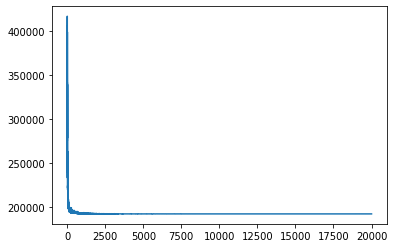

In [19]:
%%time
alt_approx, alt_trace = fit_fixed_topology_variational_approximation(
    alt_model_pinned,
    topologies=dict(tree=tree.topology),
    optimizer=optimizer,
    num_steps=num_steps,
)
plt.plot(alt_trace.loss)

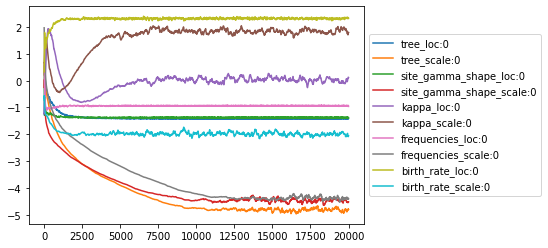

In [82]:
for varname, value in alt_trace.parameters.items():
    np_value = value.numpy()
    if len(np_value.shape) > 1:
        np_value = np_value[:, -1]
    plt.plot(np_value, label=varname)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

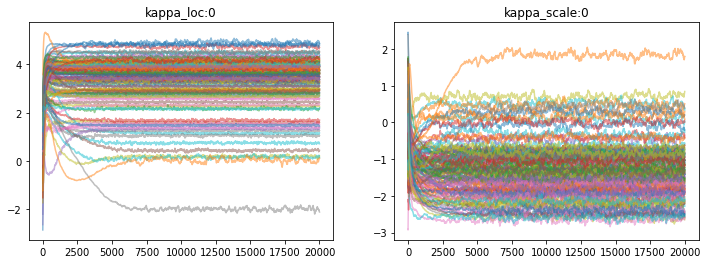

In [81]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for ax, varname in zip(axs, ["kappa_loc:0", "kappa_scale:0"]):
    ax.plot(alt_trace.parameters[varname].numpy(), alpha=0.5)
    ax.set_title(varname)

/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


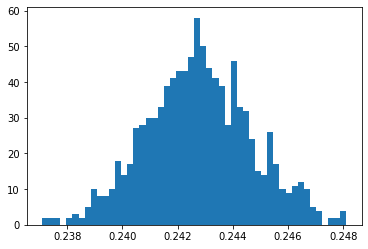

In [24]:
alt_samples = alt_approx.sample(n_samples)
plt.hist(alt_samples["tree"].node_heights[:, -1].numpy(), bins=50);

In [25]:
alt_out_samples = dict(alt_samples)
alt_tree_samples = alt_out_samples.pop("tree")
write_tensor_trees(
    "demo-data/carnivores.newick",
    alt_tree_samples.branch_lengths,
    "demo-out/carnivores-alt-trees.nexus",
    branch_metadata=dict(kappa=alt_out_samples["kappa"])
)
write_samples_to_file(
    alt_samples, alt_model_pinned, "demo-out/carnivores-alt-samples.csv", vars=alt_out_samples.keys()
)

In [27]:
alt_loss = alt_trace.loss
[tf.reduce_mean(x[-100:]) for x in [base_loss, alt_loss]]

[<tf.Tensor: shape=(), dtype=float64, numpy=193611.13923889576>,
 <tf.Tensor: shape=(), dtype=float64, numpy=192428.77222119964>]

In [28]:
import yaml
from treeflow.vi import estimate_log_ml_importance_sampling

ml_n_samples = 100
base_ml_result = estimate_log_ml_importance_sampling(base_model_pinned, base_approx, vectorize_log_prob=False, n_samples=ml_n_samples)
alt_ml_result = estimate_log_ml_importance_sampling(alt_model_pinned, alt_approx, vectorize_log_prob=False, n_samples=ml_n_samples)

marginal_likelihood_dict = dict(
    base=base_ml_result.numpy(),
    lineage_variation=alt_ml_result.numpy()
)

with open("demo-out/carnivores-marginal-log-likelihoods.yaml", "w") as f:
    yaml.dump(marginal_likelihood_dict, f)

/home/christiaan/uni/treeflow/treeflow/tf_util/attrs.py:7: UserWarning: Temporary hotfix
  warnings.warn("Temporary hotfix")


Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef({'birth_rate': HashableWeakRef(<weakref at 0x7f6162f0c400; to 'Tensor' at 0x7f61631905e0>), 'tree': HashableWeakRef(<weakref at 0x7f6162f0c540; dead>), 'site_gamma_shape': HashableWeakRef(<weakref at 0x7f6162f0c4f0; to 'Tensor' at 0x7f6188c06e50>), 'kappa': HashableWeakRef(<weakref at 0x7f6162f0c4a0; to 'Tensor' at 0x7f6163218850>), 'frequencies': HashableWeakRef(<weakref at 0x7f6162f0c450; dead>)})>
Traceback (most recent call last):
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 151, in _cleanup
    self._callback(self)
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 221, in maybe_del
    del self[key]
KeyError: WeakStructRef({'birth_rate': HashableWeakRef(<weakref at 0x7f6162f0c400; to 'Tensor' at 0x7f61631

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef({'birth_rate': HashableWeakRef(<weakref at 0x7f6162e27770; to 'Tensor' at 0x7f61630c8d60>), 'tree': HashableWeakRef(<weakref at 0x7f6162e278b0; dead>), 'site_gamma_shape': HashableWeakRef(<weakref at 0x7f6162e27860; to 'Tensor' at 0x7f6162f7b730>), 'kappa': HashableWeakRef(<weakref at 0x7f6162e27810; dead>), 'frequencies': HashableWeakRef(<weakref at 0x7f6162e277c0; to 'Tensor' at 0x7f616311f520>)})>
Traceback (most recent call last):
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 151, in _cleanup
    self._callback(self)
  File "/home/christiaan/.pyenv/versions/3.8.13/envs/treeflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/cache_util.py", line 221, in maybe_del
    del self[key]
KeyError: WeakStructRef({'birth_rate': HashableWeakRef(<weakref at 0x7f6162e27770; to 'Tensor' at 0x7f61630

{'base': -193602.3152756842, 'lineage_variation': -192421.4299731166}

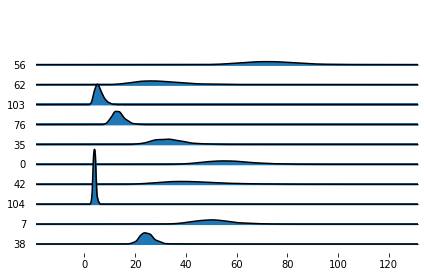

In [62]:
import joypy
import numpy as np
import pandas as pd

kappa_df = pd.DataFrame(alt_samples["kappa"].numpy())
n_columns = 10
columns = np.random.choice(kappa_df.columns, n_columns, replace=False)
joypy.joyplot(kappa_df[columns]);

In [38]:
alt_trees.topology.parent_indices

<tf.Tensor: shape=(122,), dtype=int32, numpy=
array([ 62,  62,  63,  64,  65,  65,  66,  67,  69,  70,  70,  71,  72,
        73,  73,  75,  75,  77,  77,  78,  78,  79,  80,  80,  82,  84,
        85,  87,  87,  88,  89,  89,  91,  92,  93,  93,  95,  96,  98,
        98,  99, 100, 100, 101, 103, 104, 105, 106, 106, 107, 110, 110,
       111, 112, 112, 114, 115, 116, 118, 118, 119, 119,  63,  64,  68,
        66,  67,  68,  69, 122,  71,  72,  74,  74,  76,  76,  86,  83,
        79,  81,  81,  82,  83,  84,  85,  86,  97,  88,  90,  90,  91,
        92,  94,  94,  95,  96,  97, 109,  99, 102, 101, 102, 103, 104,
       105, 108, 107, 108, 109, 117, 111, 113, 113, 114, 115, 116, 117,
       121, 120, 120, 121, 122], dtype=int32)>

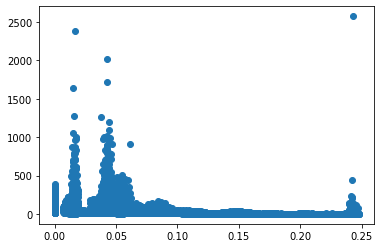

In [51]:
alt_trees = alt_samples["tree"]
parent_indices = alt_trees.topology.parent_indices
parent_indices_b = tf.broadcast_to(parent_indices, alt_trees.heights.shape[:1] + parent_indices.shape)
branch_centre = (tf.gather(alt_trees.heights, parent_indices_b, batch_dims=1) + alt_trees.heights[..., :-1]) / 2.0
plt.scatter(branch_centre.numpy(), alt_samples["kappa"].numpy())

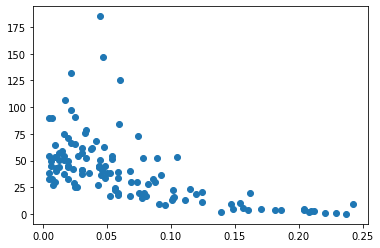

In [57]:
plt.scatter(branch_centre.numpy().mean(axis=0), alt_samples["kappa"].numpy().mean(axis=0))

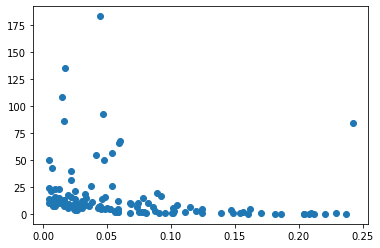

In [59]:
plt.scatter(branch_centre.numpy().mean(axis=0), alt_samples["kappa"].numpy().std(axis=0))

In [6]:
from treeflow.model.ml import fit_fixed_topology_maximum_likelihood_sgd

alt_ml_vars, alt_ml_trace, alt_ml_bijector = fit_fixed_topology_maximum_likelihood_sgd(
    alt_model_pinned,
    dict(tree=tree.topology),
    20000
)
plt.plot(alt_ml_trace.log_likelihood.numpy())

NameError: name 'plt' is not defined

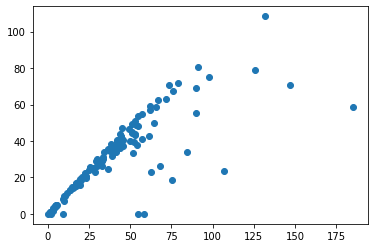

In [68]:
plt.scatter(alt_samples["kappa"].numpy().mean(axis=0), alt_ml_vars["kappa"].numpy())

## Results visualisation


* Use existing tree viz tools